# Air Mass Factor Calculation with MC

In this example we calculate a box air mass factor profile by tracking the length of each ray within each atmospheric "box" (layer).

In [1]:
%matplotlib inline

In [2]:
import sasktran as sk
import matplotlib.pyplot as plt
import numpy as np
from sasktran.geometry import VerticalImage

# First recreate our geometry and atmosphere classes
geometry = sk.NadirGeometry()

tempo = sk.Geodetic()
tempo.from_lat_lon_alt(0, -100, 35786000)

geometry.from_lat_lon(lats=52.131638, lons=-106.633873, elevations=0,
    mjd=57906.843, observer=tempo
)

atmosphere = sk.Atmosphere()
atmosphere['ozone'] = sk.Species(sk.O3OSIRISRes(), sk.Labow())
atmosphere['air'] = sk.Species(sk.Rayleigh(), sk.MSIS90())
atmosphere['no2'] = sk.Species(sk.NO2OSIRISRes(), sk.Pratmo())
atmosphere.brdf = 0.05

# And now make the engine
engine = sk.EngineMC(geometry=geometry, atmosphere=atmosphere)

engine.max_photons_per_los = 1000  # cap the calculation at 1000 rays per line of sight
engine.solar_table_type = 0        # calculate single scatter source terms on the fly; no cache
engine.debug_mode = 1234           # disable multi-threading, fix rng seed for reproducibility
engine.min_fraction_higher_order = 1  # disable higher order optimization

engine.air_mass_factor = 1         # calculate air mass factors using path length
engine.air_mass_factor_shells = np.linspace(0, 6e4, 61)  # define amf layers

# Choose a wavelength to do the calculation at
engine.wavelengths = [440.]

# And do the calculation
engine_output = engine.calculate_radiance()

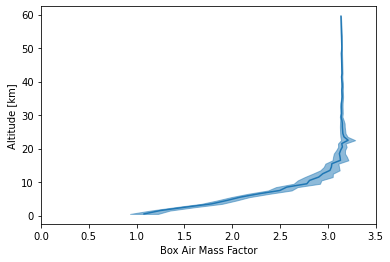

In [3]:
alts = 5e-4 * (engine.air_mass_factor_shells[:-1] + engine.air_mass_factor_shells[1:])
amf = engine_output.air_mass_factor[0][0]
stdev = np.sqrt(engine_output.air_mass_factor_variance[0][0])

plt.plot(amf, alts, 'C0')
plt.fill_betweenx(alts, amf - stdev, amf + stdev, color='C0', alpha=0.5)
plt.xlim([0, 3.5])
plt.xlabel('Box Air Mass Factor')
plt.ylabel('Altitude [km]')   

plt.show()